In [1]:
import pandas as pd
import numpy as np  
from datetime import datetime 
from functions.Team_Augury_load_transform_saved import load_and_preprocess
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cla, figure
import altair as alt
from altair_saver import save
from sklearn.inspection import permutation_importance


In [2]:
X_train, y_train = load_and_preprocess()
print ('Testing load, length of X, y:', X_train.shape, y_train.shape)
print ('type', type(X_train))

Loading features...
data loaded and pre_processed
Testing load, length of X, y: (1674, 776) (1674,)
type <class 'pandas.core.frame.DataFrame'>


In [3]:
#load pkl'd SVC clf
filename = "models/SVC_vanilla_model.sav" #note this is the 'Vanillia model', not the optimised tuned one, assume kernel = rbf
SVC_loaded = pickle.load(open(filename, 'rb'))

#test load
result = SVC_loaded.score(X_train, y_train)
print('Testing model load: Accuracy result for GBT:' , result)

Testing model load: Accuracy result for GBT: 0.9097968936678614


In [4]:
#Get perm/feature importances ## NB THIS TOOK 88 mins, so written to pkl for future uses 
# perm_importance = permutation_importance(SVC_loaded, X_train, y_train)
# print (len(perm_importance))

In [5]:
filename = "models/SVM_feat_imp_bunch_object_vanilla_model.sav"
#pickle.dump(perm_importance, open(filename, 'wb')) #the code to dump it
perm_importance = pickle.load(open(filename, 'rb')) #the code to load it

In [6]:
type(perm_importance)

sklearn.utils.Bunch

In [7]:
sorted_idx = perm_importance.importances_mean.argsort()

In [8]:
len(sorted_idx)

776

In [9]:
len(X_train.columns)

776

In [10]:
features = np.array(list(X_train.columns.values))

In [11]:
## Unhash this block to create viz of feature importance for all 776 features sorted by size
# figure(figsize=(10, 80), dpi=100)
# plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")
# plt.savefig("saved_work/SVC_long_feat_imp.png")

In [12]:
bert_idx = np.flatnonzero(np.char.find(features, "bert")!=-1)
len(bert_idx)

768

In [13]:
features[388] #shows post_sbert are 5:388 and comments sbert are 392:775 in between are 389:392

'post_sbert_384'

In [14]:
sbert_post_sum = np.sum(perm_importance.importances_mean[5:388])
sbert_comm_sum = np.sum(perm_importance.importances_mean[392:775])
print (sbert_post_sum, sbert_comm_sum)

0.37132616487456205 0.12162485065711344


In [15]:
# Having located the sbert items they now need removing from both feature names and scoring arrays
ind = np.indices(features.shape)[0]
mylist=(slice(5,389),slice(392,776))
rm = np.hstack([ind[i] for i in mylist])
simplified_names = np.take(features, sorted(set(ind)-set(rm)))
print(simplified_names) # should be small enough for visual confirmation
simplified_fi_scores = np.take(perm_importance.importances_mean, sorted(set(ind)-set(rm)) )
print (simplified_fi_scores)

['post_author_karma' 'number_comments_vs_hrs' 'post_sentiment' 'time_hour'
 'day_of_week' 'avg_comment_upvotes_vs_hrs' 'avg_comment_author_karma'
 'avg_comment_sentiment']
[ 0.00657109  0.01015532 -0.00023895  0.00728793  0.00549582  0.01565114
  0.00669056  0.00059737]


In [16]:
#Now just need to add sbert agregated names and scores to each array
sb_simplified_names = np.append(simplified_names, ['SBERT_Post','SBERT_Comment_Avg'])
sb_simplified_fi_scores = np.append(simplified_fi_scores, [sbert_post_sum, sbert_comm_sum]) 
sb_sorted_idx = np.argsort(sb_simplified_fi_scores)

In [17]:
sb_sorted_idx

array([2, 7, 4, 0, 6, 3, 1, 5, 9, 8])

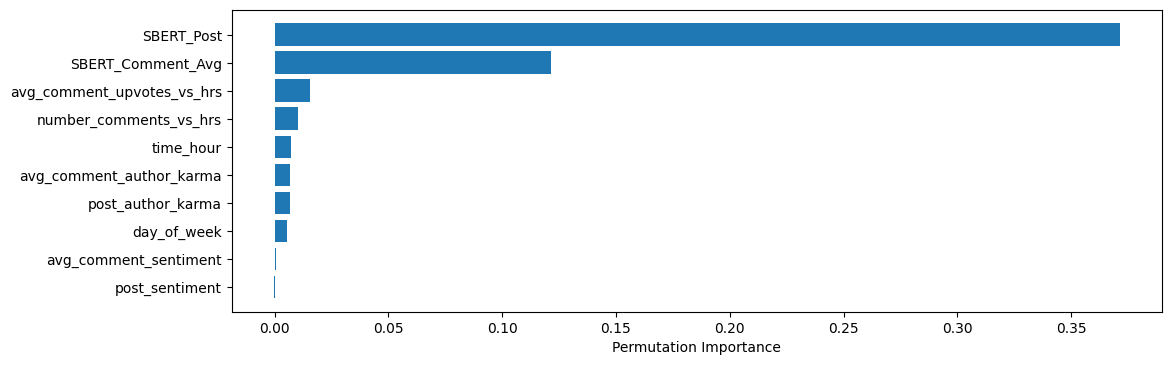

In [25]:
figure(figsize=(12, 4), dpi=100)
#plt.tight_layout()
plt.barh(sb_simplified_names[sb_sorted_idx], sb_simplified_fi_scores[sb_sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig("saved_work/SVC_simple_feat_imp.jpg", bbox_inches='tight')#note works for .jpg but fails for .png